In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import time, sys, os
sys.path.append('../')
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from utils.constants import *
import numpy as np
import pandas as pd
from tqdm import trange
from itertools import repeat

import torch
from torch.distributions import Categorical
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Module
from torch_geometric.utils import is_undirected, contains_self_loops


from scipy.spatial.distance import cdist
import scipy.io as sio
import umap

from tqdm import tqdm, trange
from termcolor import cprint

from utils.utils import load_config, diff, Trainer
from utils.utils import get_labels, remap_to_ordered_ids, tonp
from utils.utils import getLimitsOfContigElements, get_continuous_indices
from utils.graph_conversion import makeGraphDataPoint, convertToGraphs
from utils.losses import CentroidProximityLoss, DispersionLoss, L2_loss, DimensionSimilarityLoss, SelfSimilarityLoss
from utils.synthetic import sort_with_behavioral, scale, minmax, get_background 
from utils.synthetic import linear_track_back_and_forth, gaussian, get_background2 
from utils.synthetic import embed_fwd_rev_seq, embed_one_seq, embed_three_seq
from utils.graph_utils import get_graph_stats, plotWeightedGraph
from utils.plotting import plot_raster, Plot, save_data_for_figure
from utils.nulldist_2 import estimate_null
from utils.utils import get_significants, clusterize, HiddenPrints
from utils.utils import getOutputEmbeddingSimMatrix



# from models.models import SeqNetMuSigma, SeqNetClust
from models.models import WeightedGCN
from models.Kmeans import Kmeans

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.profile import get_data_size

from scipy.special import softmax
from torch.utils.tensorboard import SummaryWriter

import resource
torch.multiprocessing.set_sharing_strategy('file_system') 
print(torch.multiprocessing.get_sharing_strategy())
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))


matplotlib.rcParams.update(load_config('../configs/rcparams.yaml'))

Python version: 3
running non-deterministic
1.12.1+cu116
file_system


In [3]:
# for correct reproducibility, you should get (array([5, 0, 3, 3, 7]), tensor([4, 9, 3, 0, 3]))
np.random.randint(10, size=5), torch.randint(10, size=(5,))

(array([6, 7, 0, 4, 2]), tensor([9, 7, 7, 4, 8]))

In [6]:
# load the parameters from YAML file

params = load_config('../configs/config.yaml')
params.fs = 1/params.dt # sampling rate

adding noise
Pruning factor: 0.0
Before spike pruning: 4989.0 spikes.


100%|██████████| 76/76 [00:00<00:00, 170.88it/s]                                                                              

After spike pruning: 4989.0 spikes.


(0.0, 9000.0)

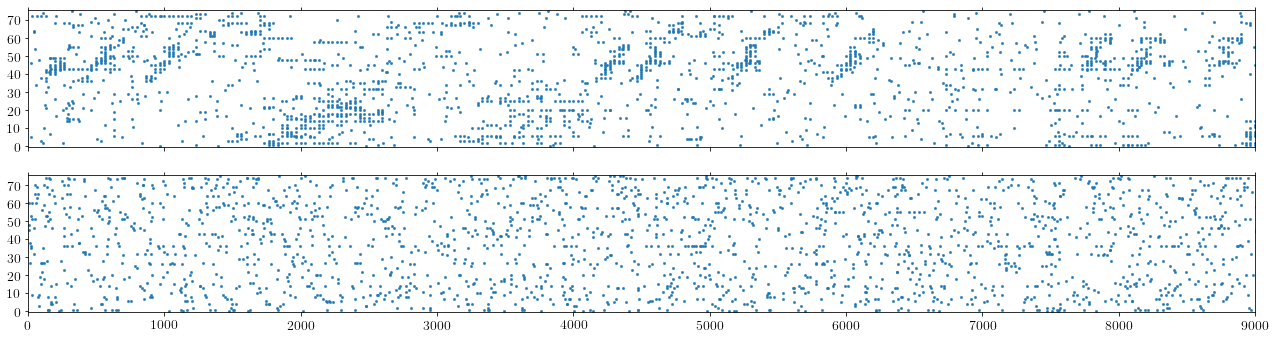

In [29]:
# load HVC data

X_ = np.load('../datasets/HVC.npy')

cprint('adding noise', color='blue')
for i in range(X_.shape[0]):
    for j in range(X_.shape[1]):
        if np.random.rand() < 0.001:
            X_[i,j] = 1
        
Xnull = get_background2(X_, pruning_factor=0.0)

params.N = X_.shape[0]
params.Ts = X_.shape[1]

fig, ax = plt.subplots(2, 1, figsize=(18,5), sharex=True)
ax[0].spy(X_, aspect='auto', markersize=1.5, origin='lower')
ax[1].spy(Xnull, aspect='auto', markersize=1.5, origin='lower')
ax[1].set_xlim(0, 9000)


In [30]:
params.Ts, params.N

(22201, 76)

In [31]:
# convert to graphs 
winsize = 150
step_sz = 4
tau = 25

    
DATA = convertToGraphs(X_, winsize, step_sz, tau, num_workers=20)   
DATAnull = convertToGraphs(Xnull, winsize, step_sz, tau, num_workers=20)

# move data to device
for i in trange(len(DATA), bar_format=bar_format):
    DATA[i] = DATA[i].to(device=params.device)
    
# move data to device
for i in trange(len(DATAnull), bar_format=bar_format):
    DATAnull[i] = DATAnull[i].to(device=params.device)

100%|██████████| 5513/5513 [00:00<00:00, 84828.07it/s]                                                                        

dataset_sz_MB: 29.67 | num_datapoints: 5513



100%|██████████| 5513/5513 [00:00<00:00, 88456.69it/s]                                                                        


dataset_sz_MB: 41.58 | num_datapoints: 5513


100%|██████████| 5513/5513 [00:00<00:00, 10674.98it/s]                                                                        


Text(0.5, 1.0, 'tau=25')

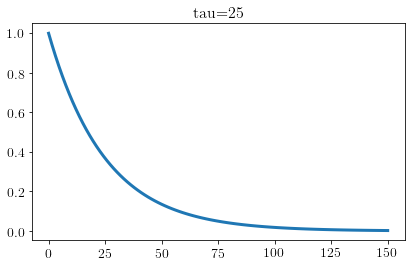

In [32]:
time_gap = np.linspace(0.001, winsize, 100)
exp_wgt = np.exp(-time_gap/tau)

plt.plot(time_gap, exp_wgt)
plt.title(f'tau={tau}')

In [33]:
%autoreload 2

from models.models import WeightedGCN
# from models.Kmeans_new import Kmeans
from models.Kmeans import Kmeans
from utils.GNNTrainer import Trainer

deterministic = False

params.z_dim = 3
params.K = 3

model = WeightedGCN(params).to(params.device)
kmeans = Kmeans(params, debug=False)
writer = SummaryWriter(log_dir='../runs/')
optimizer = optim.AdamW(model.parameters(), lr=0.05) # tell the optimizer which var we want optimized
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.05, total_iters=100)
trainer = Trainer(DATA, X_, model, optimizer, scheduler, kmeans, params, step_sz)

fnames = [i for i in os.listdir("../data/") if i.startswith('proj')]
for fn in fnames:
    os.remove(f"../data/{fn}")

Number of parameters in model: 802
WeightedGCN(
  (embed): Embedding(76, 10)
  (convs): ModuleList(
    (0): GCNConv(10, 3)
  )
  (activate): Identity()
  (drop): Dropout(p=0.0, inplace=False)
  (readout): Sequential(
    (0): Linear(in_features=3, out_features=3, bias=False)
  )
)


In [34]:
# optimizer = optim.AdamW(model.parameters()) # tell the optimizer which var we want optimized
# scheduler = None

PROXIMITY: -6.38 | VAR: 0.00 | ENTROPY: 0.00 | XENT: 0.12 | DISPERS: 0.00 | L2: 1.55 | TV: 0.42 | JUMPINESS: 0.03 | DIVERSITY:

User interrupt


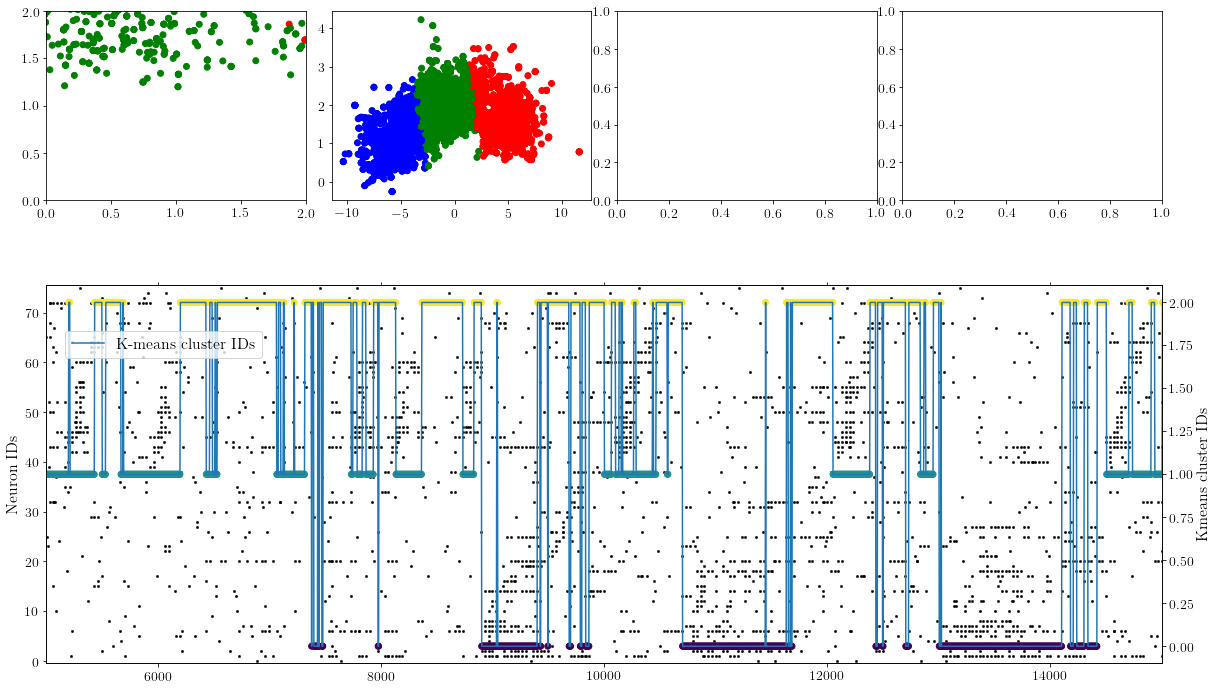

In [35]:
trainer.MAX_EPOCHS = 300
trainer.train()

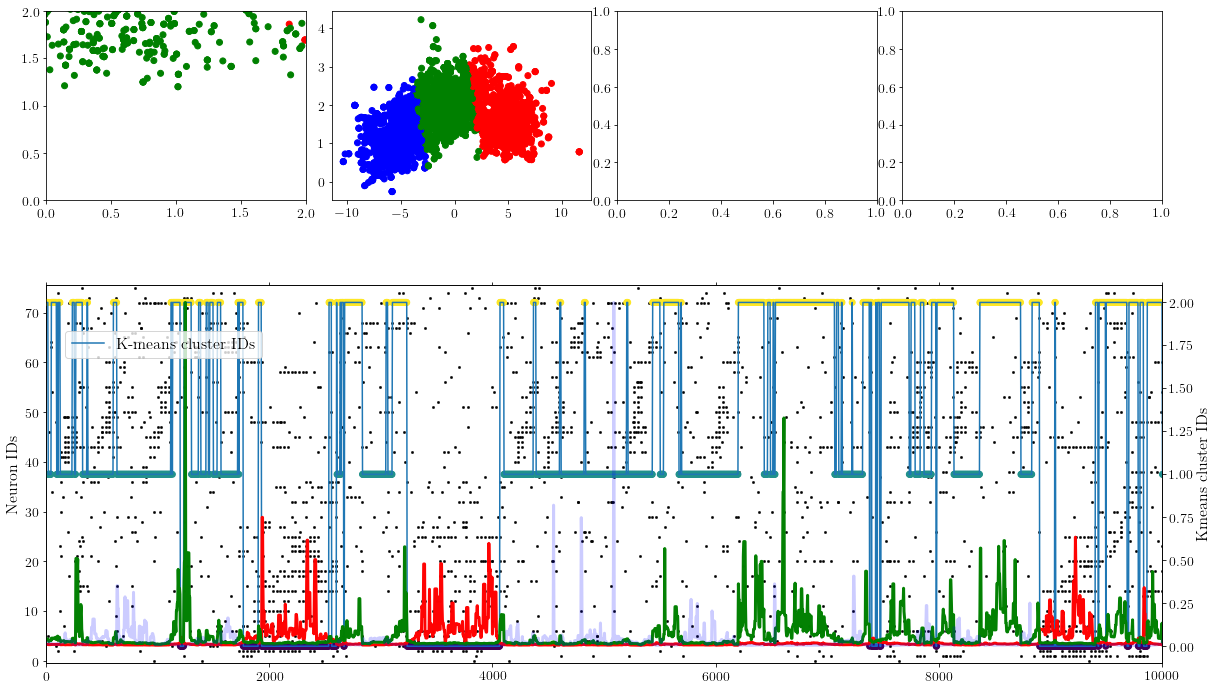

In [36]:
ax = trainer.plot(LIM=(0, 10000))
x = np.arange(0, len(trainer.embeds_np) * step_sz, step_sz)
proximities = np.reciprocal(cdist(trainer.embeds_np, tonp(kmeans.centroids), metric='euclidean'))
proximities /= proximities.max(axis=0)
proximities *= params.K - 1

for i, c in zip(range(params.K), colors):
    if i in [0, 1]:
        ax.plot(x, proximities[:,i], c=c, alpha=0.99)
    else:
        ax.plot(x, proximities[:,i], c=c, alpha=0.2)

# make figures comparing the methods' predictions

In [244]:
def plot_raster(X, ids, step_sz, logits, params, LIM, ax):
    ax.spy(X, aspect='auto', markersize=1.5, origin='lower', color='black')
    axt = ax.twinx()

    x = np.arange(0, len(tonp(ids)) * step_sz, step_sz)
    # y = remap_to_ordered_ids(ids)
    y = tonp(ids)
    axt.plot(x, y, lw=1.5, label='K-means cluster IDs')
#     axt.scatter(x, y, c=[colors[i] for i in y])
    c=[colors[i] for i in y]
    for x_, y_, c_ in tqdm(zip(x, y, c), bar_format=bar_format):
        if c_ != 'green':
            axt.scatter(x_, y_, c=c_)
    preds = remap_to_ordered_ids(logits.argmax(dim=1))
    # axt.plot(np.arange(0, len(ids) * step_sz, step_sz), preds, 'bo', alpha=0.3, label='argmax(logits)')

    # axt.plot(dat1/100*params.K, 'r')

    # axt.plot(x, labels.detach().cpu().numpy(), 'go', alpha=0.2, label='ideals')
    ax.set_xlim(LIM)
    ax.set_ylabel('Neuron IDs')

    axt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.9))
    axt.set_ylabel('Kmeans cluster IDs')
    # ax.axvspan(2900, 2900 + params.W, alpha=0.2)

    return axt

|          | 5513/? [00:09<00:00, 559.55it/s]                                                                                 


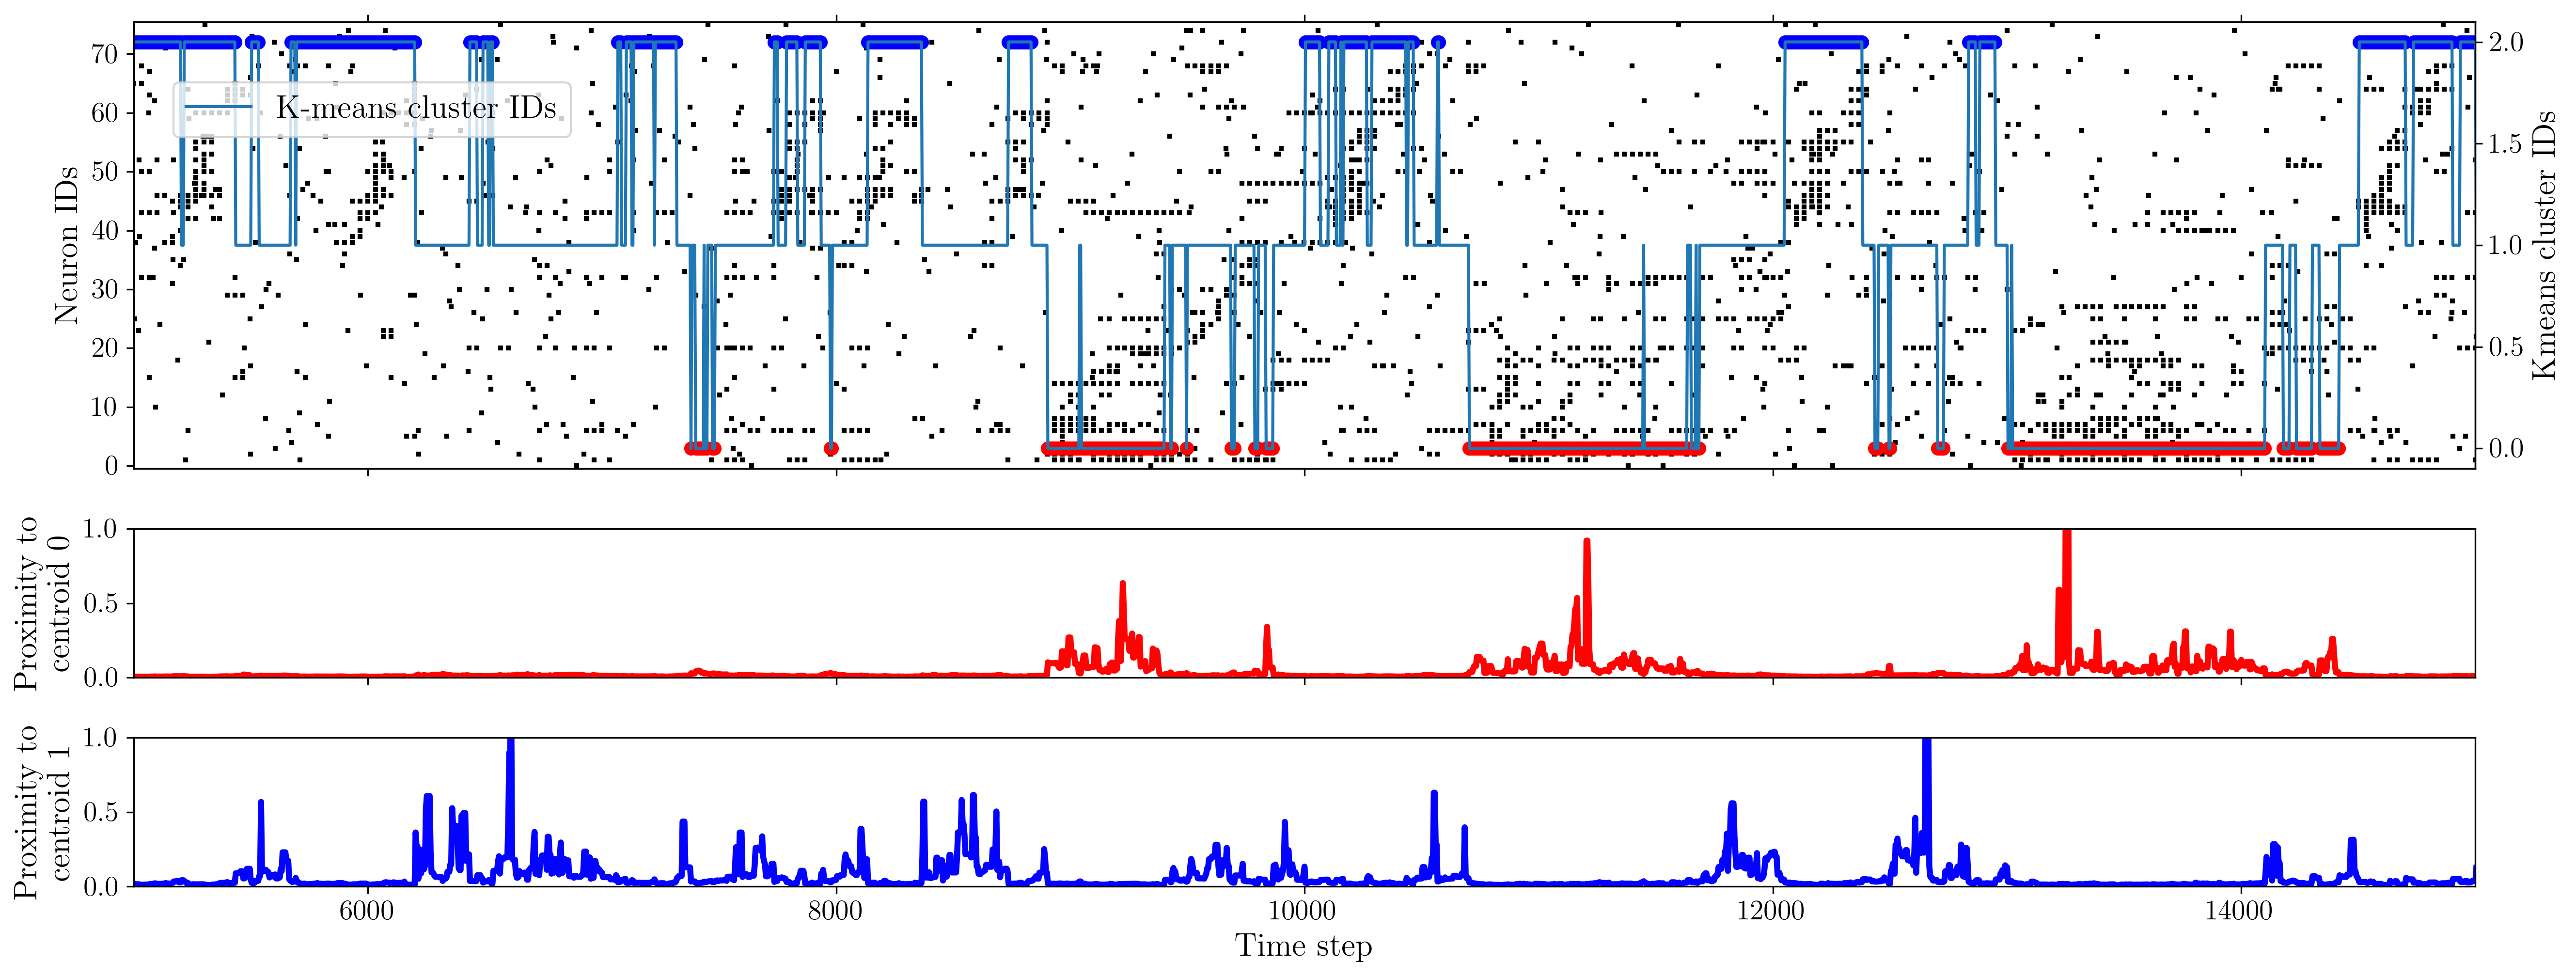

In [247]:
fig, (ax, ax1, ax3) = plt.subplots(3,1, figsize=(18,7), gridspec_kw=dict(height_ratios=[3,1,1]), sharex=True, dpi=300)

plot_raster(X_, trainer.ids, trainer.step_sz, trainer.logits, trainer.params, trainer.LIM, ax)


x = np.arange(0, len(trainer.embeds_np) * step_sz, step_sz)
proximities = np.reciprocal(cdist(trainer.embeds_np, tonp(kmeans.centroids), metric='euclidean'))
proximities /= proximities.max(axis=0)
proximities *= params.K - 1

for i, c, a in zip(range(params.K), ['red', 'blue'], (ax1, ax3)):
    a.plot(x, proximities[:,i], c=c, alpha=0.99)
    a.set_ylabel(f'Proximity to\ncentroid {i}')
    a.set_ylim(0,1)
ax3.set_xlabel("Time step")
plt.savefig("../images/HVC_ours.png", dpi=300, bbox_inches='tight')
plt.savefig("../images/HVC_ours.pdf", bbox_inches='tight')
    

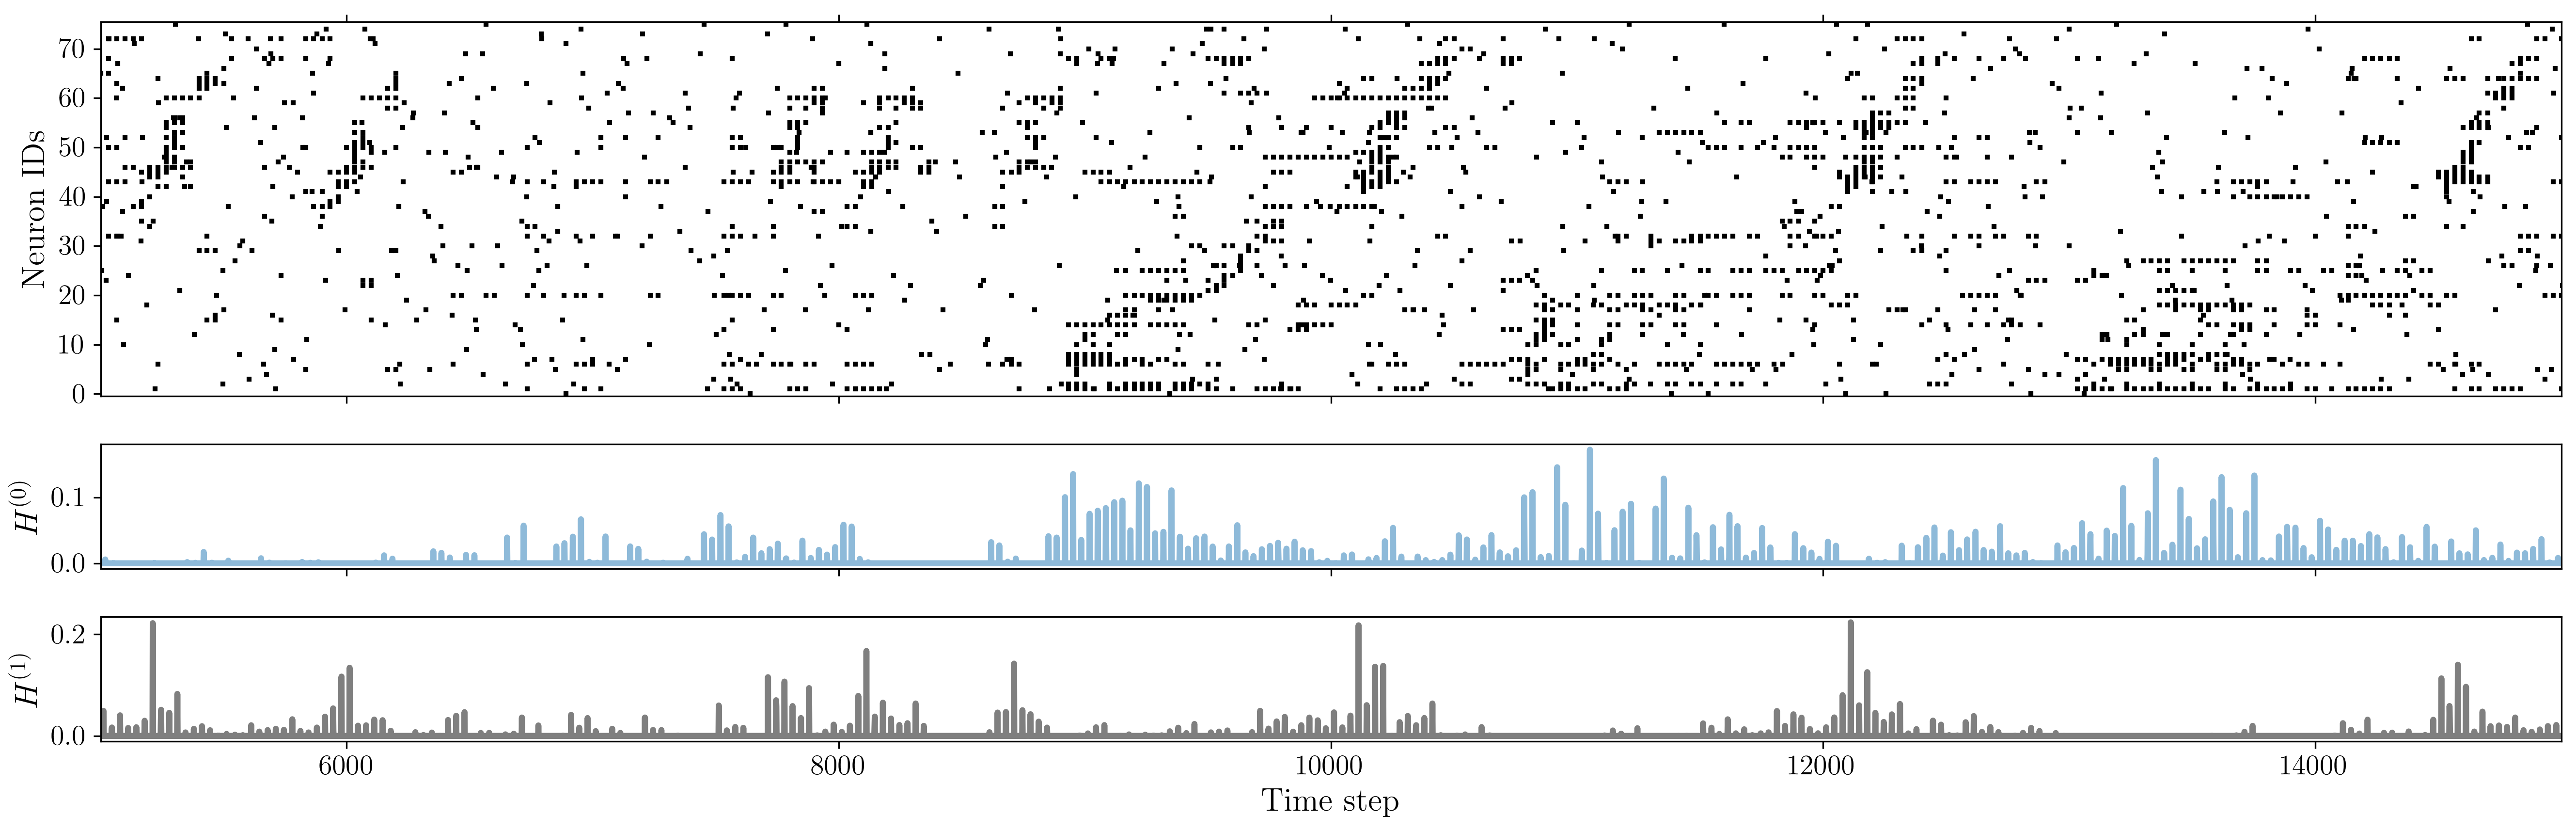

In [210]:
d = sio.loadmat('../baselines/seqNMF/seqNMF_res.mat')
H = d['H']
W = d['W']

fig, ax = plt.subplots(3, 1, figsize=(18,6),gridspec_kw=dict(height_ratios=[3,1,1]), sharex=True, dpi=300)
ax[0].spy(X_, aspect='auto', markersize=1.5, origin='lower', color='k')
ax[0].set_ylabel('Neuron IDs')

ax[1].plot(H[0,:], alpha=0.5)
ax[2].plot(H[1,:], alpha=0.5, color='k')
ax[1].set_xlim(5000, 15000)
ax[1].set_ylabel("$H^{(0)}$")
ax[2].set_ylabel("$H^{(1)}$")
ax[2].set_xlabel("Time step")
plt.savefig("../images/HVC_seqNMF.png", dpi=300, bbox_inches='tight')
plt.savefig("../images/HVC_seqNMF.pdf", bbox_inches='tight')

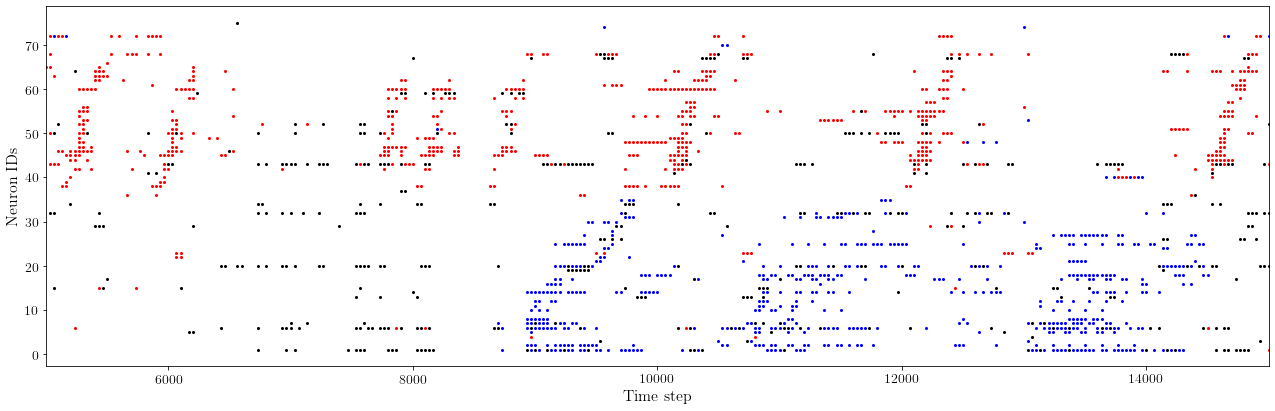

In [212]:
df = pd.read_csv('../baselines/PPSeq.jl/demo/data/songbird_spikes.txt', sep='\t', header=None)
df.columns = ['neuronid', 'spiketime']
df.neuronid = df.neuronid.astype(int)
df.spiketime = (df.spiketime * 1000).astype(int)

events = np.load('../artifacts/events.npy')
final_assignments = np.load('../artifacts/final_assignments.npy')
assignment_ids = np.load('../artifacts/assignment_ids.npy')
ordering = np.load('../artifacts/neuron_ordering.npy')
amplitudes = np.load('../artifacts/amplitudes.npy')
seq_type = np.load('../artifacts/seq_type.npy')

yidx = np.argsort(ordering)
typemap = {int(i): int(j) for i, j in zip(assignment_ids, seq_type)}

_x, _y = np.zeros((df.shape[0],), dtype=np.float), np.zeros((df.shape[0],), dtype=np.int)

for i, s in df.iterrows():
    
    _x[i] = s.spiketime
    _y[i] = yidx[int(s.neuronid) - 1]

idx = []
for sa in final_assignments:
    idx.append(-1 if sa == -1 else typemap[sa])
df['idx'] = idx

fig, ax = plt.subplots(1,1, figsize=(18, 6))

df[df.idx == -1].plot(y='neuronid', x='spiketime', style='ko', ax=ax, markersize=2)
df[df.idx == 1].plot(y='neuronid', x='spiketime', style='bo', ax=ax, markersize=2)
df[df.idx == 2].plot(y='neuronid', x='spiketime', style='ro', ax=ax, markersize=2)
ax.set_xlim(5000, 15000)
ax.set_ylabel('Neuron IDs')
ax.set_xlabel("Time step")
ax.legend().remove()
plt.savefig("../images/HVC_PP_seq.png", dpi=300, bbox_inches='tight')
plt.savefig("../images/HVC_PP_seq.pdf", bbox_inches='tight')

# Null data

In [210]:
fnames = [i for i in os.listdir("../data/") if i.startswith('proj')]
for fn in fnames:
    os.remove(f"../data/{fn}")

null_model = WeightedGCN(params).to(params.device)
null_kmeans = Kmeans(params, debug=False)
null_writer = SummaryWriter(log_dir='../runs/')
null_optimizer = optim.AdamW(null_model.parameters(), lr=0.05) # tell the optimizer which var we want optimized
null_scheduler = torch.optim.lr_scheduler.LinearLR(null_optimizer, start_factor=0.05, total_iters=200)
null_trainer = Trainer(DATAnull, Xnull, null_model, null_optimizer, null_scheduler, null_kmeans, params, step_sz)

Number of parameters in model: 802
WeightedGCN(
  (embed): Embedding(76, 10)
  (convs): ModuleList(
    (0): GCNConv(10, 3)
  )
  (activate): Identity()
  (drop): Dropout(p=0.0, inplace=False)
  (readout): Sequential(
    (0): Linear(in_features=3, out_features=3, bias=False)
  )
)


In [211]:
null_trainer.MAX_EPOCHS = 400
null_trainer.train()

PROXIMITY: -5.88 | VAR: 0.00 | ENTROPY: 0.00 | XENT: 0.15 | DISPERS: 0.00 | L2: 2.58 | TV: 0.30 | JUMPINESS: 0.02 | DIVERSITY:


<AxesSubplot:ylabel='Kmeans cluster IDs'>

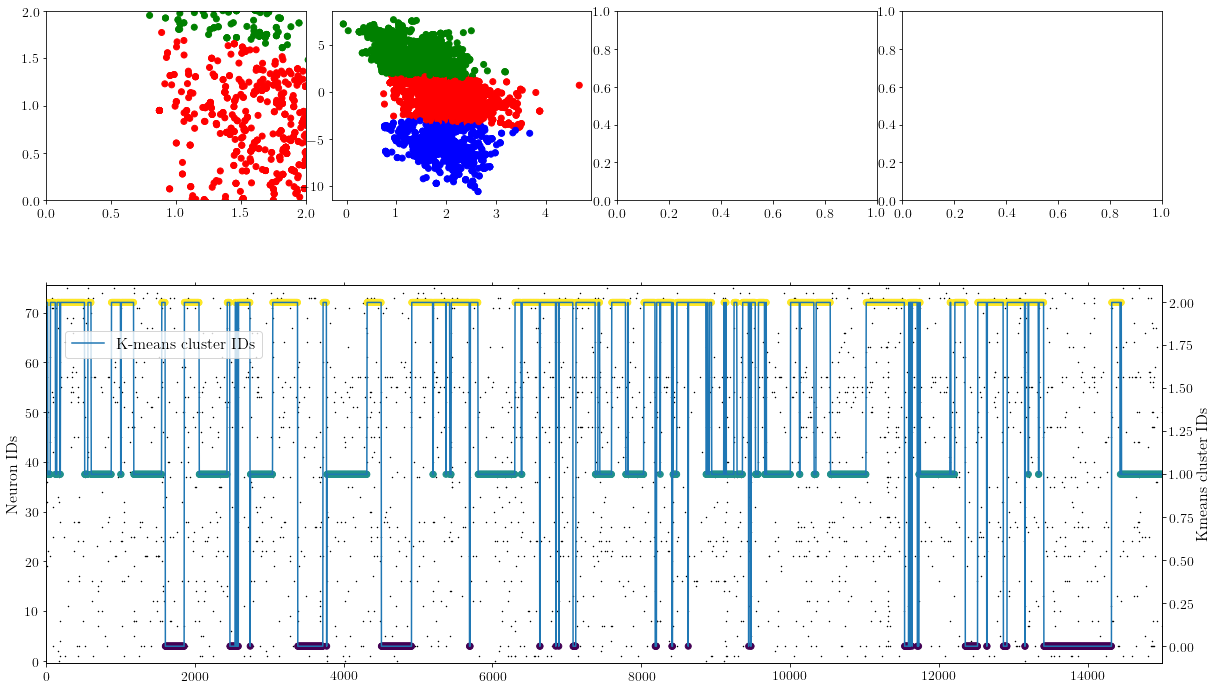

In [212]:
null_trainer.plot(LIM=(0, 15000))

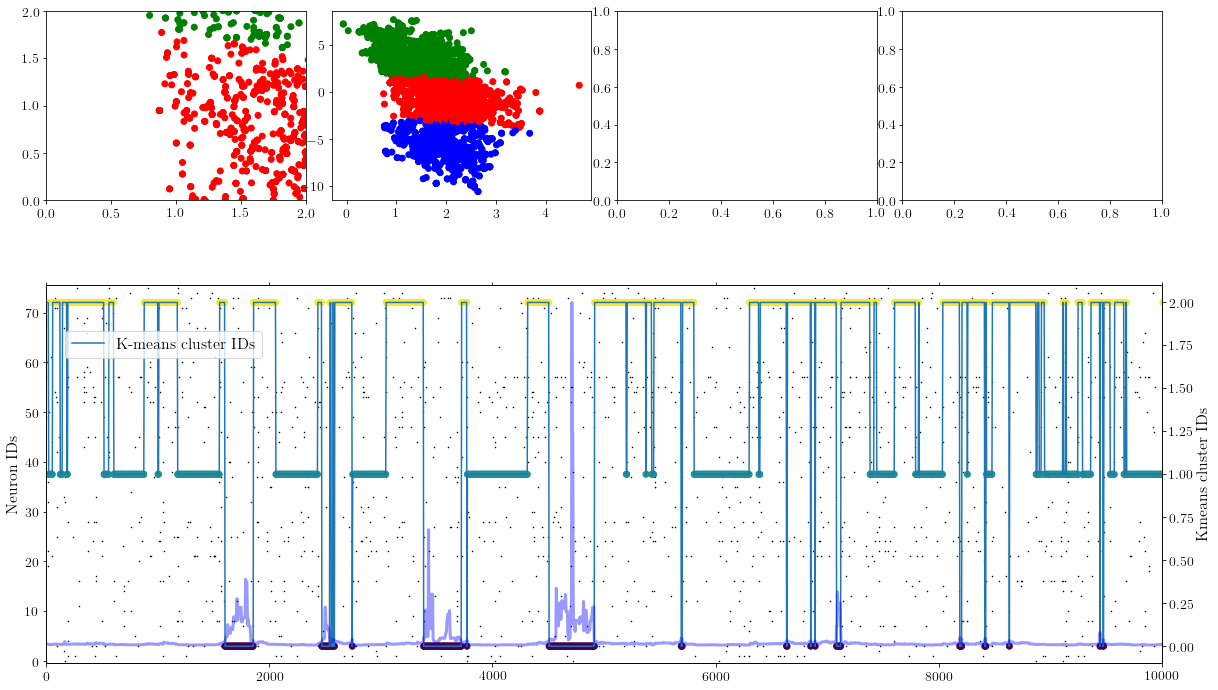

In [213]:
ax = null_trainer.plot(LIM=(0, 10000))
x = np.arange(0, len(null_trainer.embeds_np) * step_sz, step_sz)
proximities = np.reciprocal(cdist(null_trainer.embeds_np, tonp(null_kmeans.centroids), metric='euclidean'))
proximities /= proximities.max(axis=0)
proximities *= params.K - 1

for i, c in zip(range(params.K), colors):
    if i == 2:
        ax.plot(x, proximities[:,i], c=c, alpha=0.4)

Text(0.5, 0, 'Epochs')

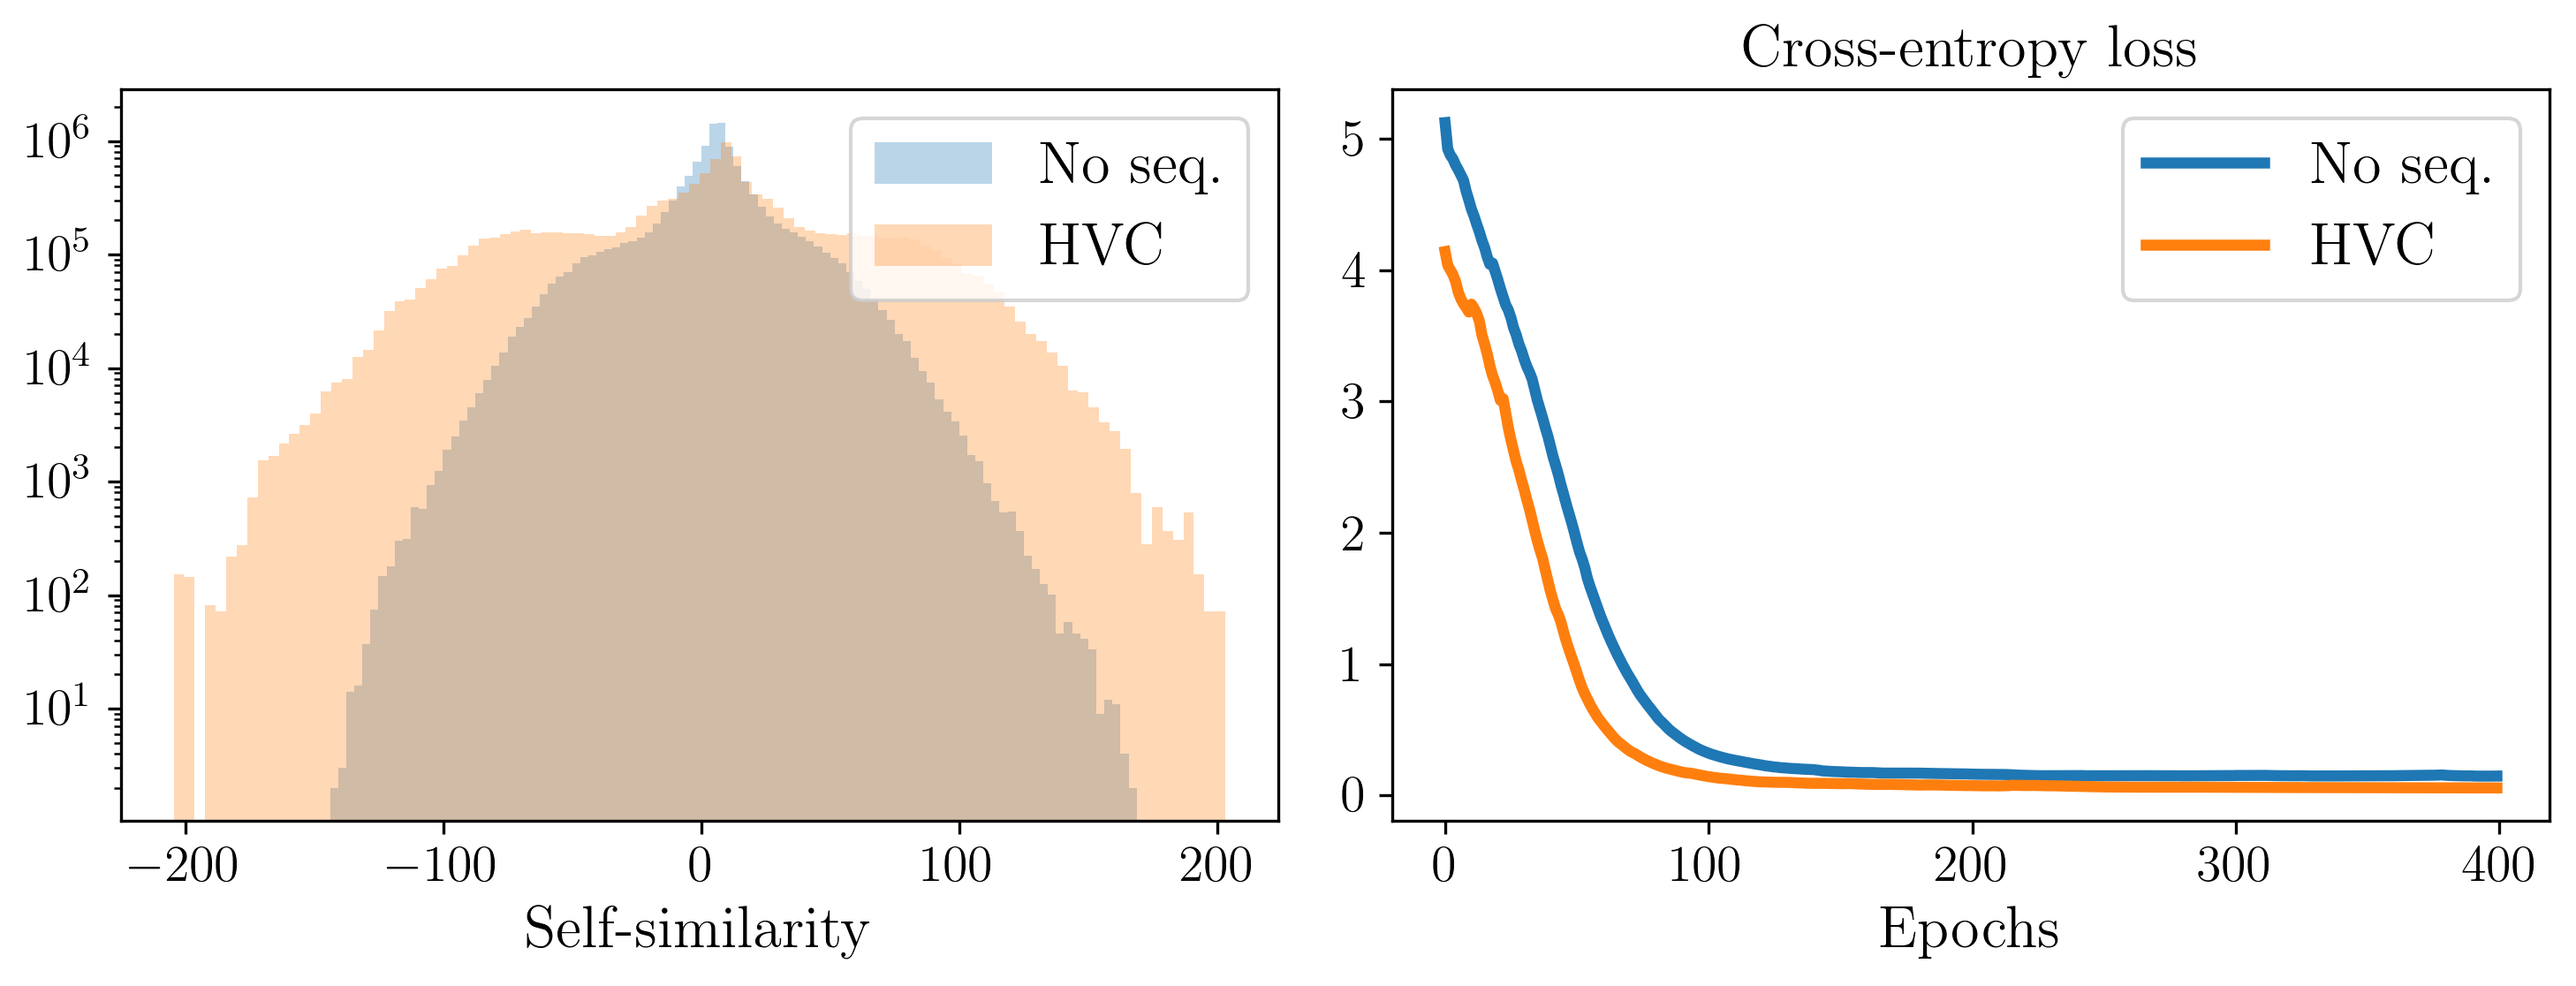

In [214]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
ax[0].set_yscale('log')

smnp_null, q_null, triu_null = getOutputEmbeddingSimMatrix(DATAnull, winsize, model=null_model, quantile=0.99, params=params)
_ = ax[0].hist(triu_null, bins=100, alpha=0.3, label='No seq.')

smnp, q, triu = getOutputEmbeddingSimMatrix(DATA, winsize, model=model, quantile=0.99, params=params)
_ = ax[0].hist(triu, bins=100, alpha=0.3, label='HVC')

ax[0].legend(loc='upper right')
ax[0].set_xlabel('Self-similarity')


xent_loss = pd.DataFrame(trainer.losses)
null_xent_loss = pd.DataFrame(null_trainer.losses)

null_xent_loss.XENT.plot(ax=ax[1], label='No seq.')
xent_loss.XENT.plot(ax=ax[1], label='HVC')
ax[1].legend(loc='upper right')
ax[1].set_title('Cross-entropy loss')
ax[1].set_xlabel('Epochs')


Text(0.5, 0.98, 'Self-similarity of INPUT embeddings')

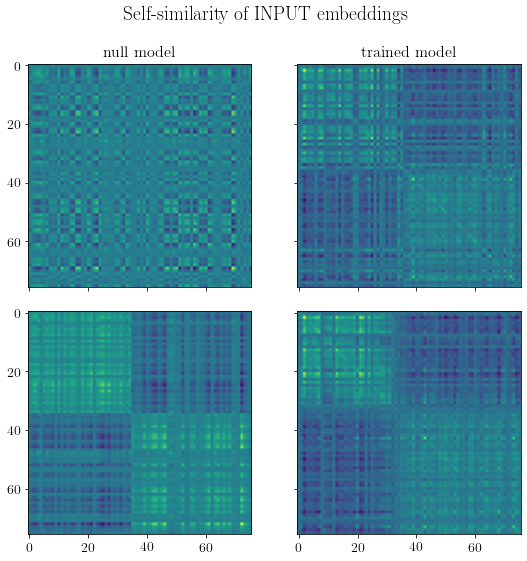

In [219]:
fig, ax = plt.subplots(2,2, figsize=(8,8), sharey=True, sharex=True)

emb = tonp(null_model.embed.weight.data)
ssnull = emb.dot(emb.T)
ssnull -= ssnull.min()
W_, labels, counts, mod, newids = clusterize(ssnull)
ax[0,0].imshow(ssnull)
ax[0,0].set_title('null model')
ax[1,0].imshow(W_)

emb = tonp(model.embed.weight.data)
ss = emb.dot(emb.T)
ss -= ss.min()
W_, labels, counts, mod, newids = clusterize(ss)
ax[0,1].imshow(ss)
ax[0,1].set_title('trained model')
ax[1,1].imshow(W_)
plt.suptitle('Self-similarity of INPUT embeddings')

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(8,8), sharey=True, sharex=True)

loader = DataLoader(DATAnull, batch_size=len(DATAnull), shuffle=False)
for batch in loader:
    pass
ems, _ = model(batch.x, batch.edge_index, batch.edge_weight, batch.batch, deterministic=deterministic)
ems = tonp(ems)
ssnull = ems.dot(ems.T)
ssnull -= ssnull.min()
W_, labels, counts, mod, newids = clusterize(ssnull)
ax[0,0].imshow(ssnull)
ax[0,0].set_title('null data')
ax[1,0].imshow(W_)

loader = DataLoader(DATA, batch_size=len(DATA), shuffle=False)
for batch in loader:
    pass
ems, _ = model(batch.x, batch.edge_index, batch.edge_weight, batch.batch, deterministic=deterministic)
ems = tonp(ems)
ss = ems.dot(ems.T)
ss -= ss.min()
W_, labels, counts, mod, newids = clusterize(ss)
ax[0,0].imshow(ss)
ax[0,0].set_title('real data')
ax[1,0].imshow(W_)
plt.suptitle('Self-similarity of OUTPUT embeddings')